In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from dotenv import load_dotenv
from langchain_teddynote import logging
from typing import List, Dict
from IPython.display import Image
from datetime import datetime
import re

In [2]:
# OpenAI API Key, langcsmith 추적 설정
# .env 파일에 API_KEY=YOUR_API_KEY 형식으로 저장

load_dotenv()
logging.langsmith('canlender')

LangSmith 추적을 시작합니다.
[프로젝트명]
canlender


In [3]:
# # OCR 결과 가져오기
# with open('easyocr_results.txt', 'r') as file:
#     ocr_result_easy = file.read()

# with open('pororo_results.txt', 'r') as file:
#     ocr_result_pororo = file.read()
# img_path = 'images/KakaoTalk_Photo_2024-08-27-17-45-59 008.jpeg'

with open('easyocr_notice.txt', 'r') as file:
    ocr_result_easy = file.read()

with open('pororo_notice.txt', 'r') as file:
    ocr_result_pororo = file.read()
img_path = 'images/notice.jpg'

In [4]:
# 비교를 위해 데이터 형식 통일
# List(([x1, y1], [x2, y2], [x3, y3], [x4, y4]), 'text') 형식으로 변환
ocr_result_easy = eval(ocr_result_easy)
ocr_result_pororo_before = eval(ocr_result_pororo)

ocr_result_pororo = []
for i in ocr_result_pororo_before['bounding_poly']:
    temp = []
    for j in i['vertices']:
        temp.append([j['x'], j['y']])
    ocr_result_pororo.append([temp, i['description']])

In [5]:
# OCR 인식결과 ex.)"113일" -> "13일"로 변환
def correct_date(date_str):
    if len(date_str) == 3 and date_str.isdigit():
        return date_str[-2:]
    return date_str

# OCR 인식결과 텍스트 중 "4월 5일" or "5일"과 같은 날짜 형식을 기준으로 분리. 
# why? 날짜 형식을 기준으로 분리하면 날짜와 그에 해당하는 내용을 쉽게 추출할 수 있기 때문.
def split_text_by_date(text):
    # 정규표현식 패턴: (숫자)월 (숫자)일 또는 (숫자)일 형태를 찾습니다.
    pattern = r'((\d+)월\s*)?(\d+)일\s*(\([^\)]+\))?\s*'
    
    # 정규표현식으로 모든 매치를 찾습니다.
    matches = list(re.finditer(pattern, text))
    
    result = []
    last_end = 0
    
    for match in matches:
        # 날짜 이전의 텍스트 처리
        if match.start() > last_end:
            result.append(f"기타: {text[last_end:match.start()].strip()}")
        
        # 날짜 정보 추출
        month = match.group(2) + '월 ' if match.group(2) else ''
        day = correct_date(match.group(3)) + '일'
        date = month + day
        
        # 요일 정보 추가 (있는 경우)
        if match.group(4):
            date += ' ' + match.group(4)
        
        # 날짜 다음의 내용 추출
        content_start = match.end()
        content_end = matches[matches.index(match) + 1].start() if matches.index(match) < len(matches) - 1 else len(text)
        content = text[content_start:content_end].strip()
        
        result.append(f"{date}: {content}")
        last_end = content_end
    
    # 마지막 날짜 이후의 텍스트 처리
    if last_end < len(text):
        result.append(f"{text[last_end:].strip()}")
    
    return '\n'.join(result)

# input data 날짜형식을 기준으로 분리
def split_text_by_date_data(data):
    for idx in range(len(data)):
        text = data[idx][1]
        split_text = split_text_by_date(text)
        try:
            data[idx][1] = split_text
        except:
            data[idx] = list(data[idx])
            data[idx][1] = split_text
    return data

In [6]:
ocr_result_easy = split_text_by_date_data(ocr_result_easy)
ocr_result_pororo = split_text_by_date_data(ocr_result_pororo)

In [7]:
# Input data 출력
display(ocr_result_easy)
print('-' * 100)
display(ocr_result_pororo)

[[[[372, 74], [620, 74], [620, 124], [372, 124]],
  '4월 가정통신문',
  0.9066128764410493],
 [[[188, 127], [814, 127], [814, 176], [188, 176]],
  '중 0 ~ ; -47 0 소3스 :요0',
  0.006224902492403827],
 [[[292, 184], [378, 184], [378, 214], [292, 214]], '때빠이', 0.5653871112970394],
 [[[387, 181], [701, 181], [701, 219], [387, 219]],
  '울올 티우는 화장안 봄날',
  0.49090565168395395],
 [[[152, 220], [846, 220], [846, 246], [152, 246]],
  '"우리 아이들은 아늘이며, 까연올 닮은 귀안 존꺼입니다. 어여쁘고 고운 아이들올',
  0.20150162052366505],
 [[[224, 254], [758, 254], [758, 278], [224, 278]],
  '따뜻안 품어 안아 마음이 넓고 깊은 아이로 팔 키우계습니다 "',
  0.6117933806620731],
 [[[130, 288], [370, 288], [370, 314], [130, 314]],
  '3월 24일 (금): 오후 6시 30분,',
  0.7946601614478829],
 [[[376, 288], [802, 288], [802, 314], [376, 314]],
  '제 1차 어린이집 운영위원회 회의 내용올 알려드컵니다 .',
  0.4939605873233817],
 [[[144, 314], [430, 314], [430, 340], [144, 340]],
  '신입 운영위원  위촉 및 연임위원  위축장',
  0.3853657995082713],
 [[[435, 317], [467, 317], [467, 335], [435, 335]], '수여', 0.99904441184580

----------------------------------------------------------------------------------------------------


[[[[372, 74], [620, 74], [620, 124], [372, 124]], '1월 가정통신문'],
 [[[120, 127], [902, 127], [902, 552], [120, 552]],
  '기타: 기기 --)이내년 새싹이 움을 턱우는 와창한 봄날 *"우리 아이들은 이늘이며, 꺼연을 닮은 귀얀 존매입니다. 어여쁘고 고운 아이들을 따뜻한 품에 안아 마음이 넓고 깊은 아이로 잘 키우겠습니다."\n3월 24일 (금): 오후 6시 30분, 제 1차 어린이집 운영위원회 회의 내용을 알려드립니다. 신입 운영위원 위촉 및 연임위원 위촉장 수여 2, 2023년 14분기 신입 원어 수입자출 정산 \' 어린이집 운영비 내부 관리 규정 보고 2023년 연간 사업계획안 보고 연간 행사전) 부모 참여 및 부모고육 연간계획안(연간 유어놀이 계획안) 무른마늘빈 연간 초등교육 창의공합 늘이만 3층 창의 융합 아플리에 공간 구성 예정 4. 2023년 어린이집 운영방안 (야간연장 및 토요보육 운영 포함) 5, 지역사회연계 협력사업 6.각 반별 신학기 어린이집 운영 제안 및 논의사항 운영위원회 자세한 회의내용을 현관에 제시하오니 참고하시기 바랍니다.'],
 [[[120, 574], [478, 574], [478, 602], [120, 602]], '4월 어린이집 행사에 대해 알려 드립니다.'],
 [[[384, 621], [490, 621], [490, 645], [384, 645]], '내용 및 대상'],
 [[[152, 622], [210, 622], [210, 646], [152, 646]], '일 시'],
 [[[725, 623], [749, 623], [749, 643], [725, 643]], '비'],
 [[[288, 658], [540, 658], [540, 946], [288, 946]],
  '식목일 행사 대상: 어린이집 전체 영유아 지진대피훈련 대상 : 어린이집 전체 영유아 한식 대상: 어린이집 전체 영유아 생일잔치 내가 세상에 태어났어요!(생일잔치) 많

# Prompt Template 설정
1. 문맥과 텍스트 위치를 고려하여 내용을 재구성하고, OCR 인식 오류로 인한 명백한 오타를 수정하세요.
2. 개인의 이름은 수정하거나 변경하지 마세요.
3. 오류 가능성이 있는 항목의 경우, 구체적인 내용 없이 일반적인 행사 유형을 전달하도록 문구를 수정하세요 (예: "빨간 망토 인형극" -> "인형극").
4. 각 행사에 대한 주요 정보(예: 연령대, 활동 유형)를 유지하세요.
5. 항상 한국어로 답변하세요.
6. 일정표에 기관 정보와 생일 정보를 포함하지 마세요.

In [8]:
template = """ 
Please organize the OCR results of a monthly event schedule into a structured format. Follow these guidelines:

1. Reconstruct the content considering the context and text location, and correct obvious typos due to OCR recognition errors.
2. Do not correct or modify names of individuals.
3. For items with potential errors, rephrase to convey the general event type without specifics (e.g., "Red Riding Hood puppet show" -> "puppet show").
4. Maintain key information about each event (e.g., age group, activity type).
5. Always answer in Korean.
6. Not include the information about the institution and the birthday in the schedule.

OCR result:
{ocr_result}

Format instructions:
{format_instructions}


Please provide an organized schedule based on these instructions.
"""


모델 지정, Json 형식 Output 형식을 위해 format_instructions 설정

In [9]:
# OpenAI GPT-4o-mini 모델 사용
model = ChatOpenAI(
    model_name = 'gpt-4o-mini',
    temperature = 0
    )

# 날짜, 활동으로 구성된 일정을 입력받아 일정을 구조화하는 클래스
class Event(BaseModel):
    date: str = Field(description="Day of the event datetime format DD(1-31)")
    activities: List[str] = Field(description="List of activities on this date")

# 일정을 구조화하는 클래스
class MonthlySchedule(BaseModel):
    events: List[Event] = Field(description="List of events for each date")
    
# 일정을 구조화하는 클래스를 통해 출력 Json 결과로 파싱
output_parser = JsonOutputParser(pydantic_object=MonthlySchedule)

prompt = PromptTemplate(
    input_variables=["ocr_result"],
    partial_variables={"format_instructions": output_parser.get_format_instructions()},
    template=template
    )

# chain 생성
chain = prompt | model | output_parser

In [16]:
# easyocr 결과 답변 생성
response_easy = chain.invoke({'ocr_result':ocr_result_easy})

In [17]:
# pororo 결과 답변 생성
response_pororo = chain.invoke({'ocr_result':ocr_result_pororo})

모델의 답변에 현재 날짜(연도-월) year_month key값으로 value 추가

In [18]:
# OCR 결과에 날짜에 대한 정보(월, 일)가 없는 경우 캘린더 날짜 지정을 위해 현재 날짜를 추출
def get_today_ym():
    return f"{datetime.today().year}년 {datetime.today().month}월"

response_easy.update({'year_month':get_today_ym()})
response_pororo.update({'year_month':get_today_ym()})

In [23]:
def fix_date(data):
    for idx in range(len(data['events'])):
        date_len = len(data['events'][idx]['date'])
        if date_len > 3:
            data['events'][idx]['date'] = data['events'][idx]['date'].split('월')[-1].replace('일', '')
        else:
            data['events'][idx]['date'] = data['events'][idx]['date'].replace('일', '')

    return data

Result of easyocr, Token: 3,143
현재 날짜(연도,월):  2024년 8월
{'date': '5', 'activities': ['식목일 행사', '대상: 어린이집 전체 영유아']}
{'date': '5', 'activities': ['지진대피훈련', '대상: 어린이집 전체']}
{'date': '6', 'activities': ['한식', '대상: 어린이집 전체 영유아']}
{'date': '19', 'activities': ['생일잔치', '내가 세상에 태어났어요!']}
{'date': '26', 'activities': ['정기 소방안전교육 및 대피훈련', '대상: 전체 영유아']}
{'date': '10', 'activities': ['학부모 개별 상담']}
----------------------------------------------------------------------------------------------------
Result of pororo, Token: 1,373
현재 날짜(연도,월) : 2024년 8월
{'date': ' 5', 'activities': ['식목일 행사', '지진대피훈련', '한식', '생일잔치', '정기 소방안전교육 및 대피훈련']}
{'date': ' 6', 'activities': ['엄마아빠 꿈 이야기']}
{'date': ' 19', 'activities': ['활동']}
{'date': ' 26', 'activities': ['화재 장소에 따른 사전 교육 및 훈련']}
{'date': ' 13', 'activities': ['학부모 개별 상담 안내']}
----------------------------------------------------------------------------------------------------


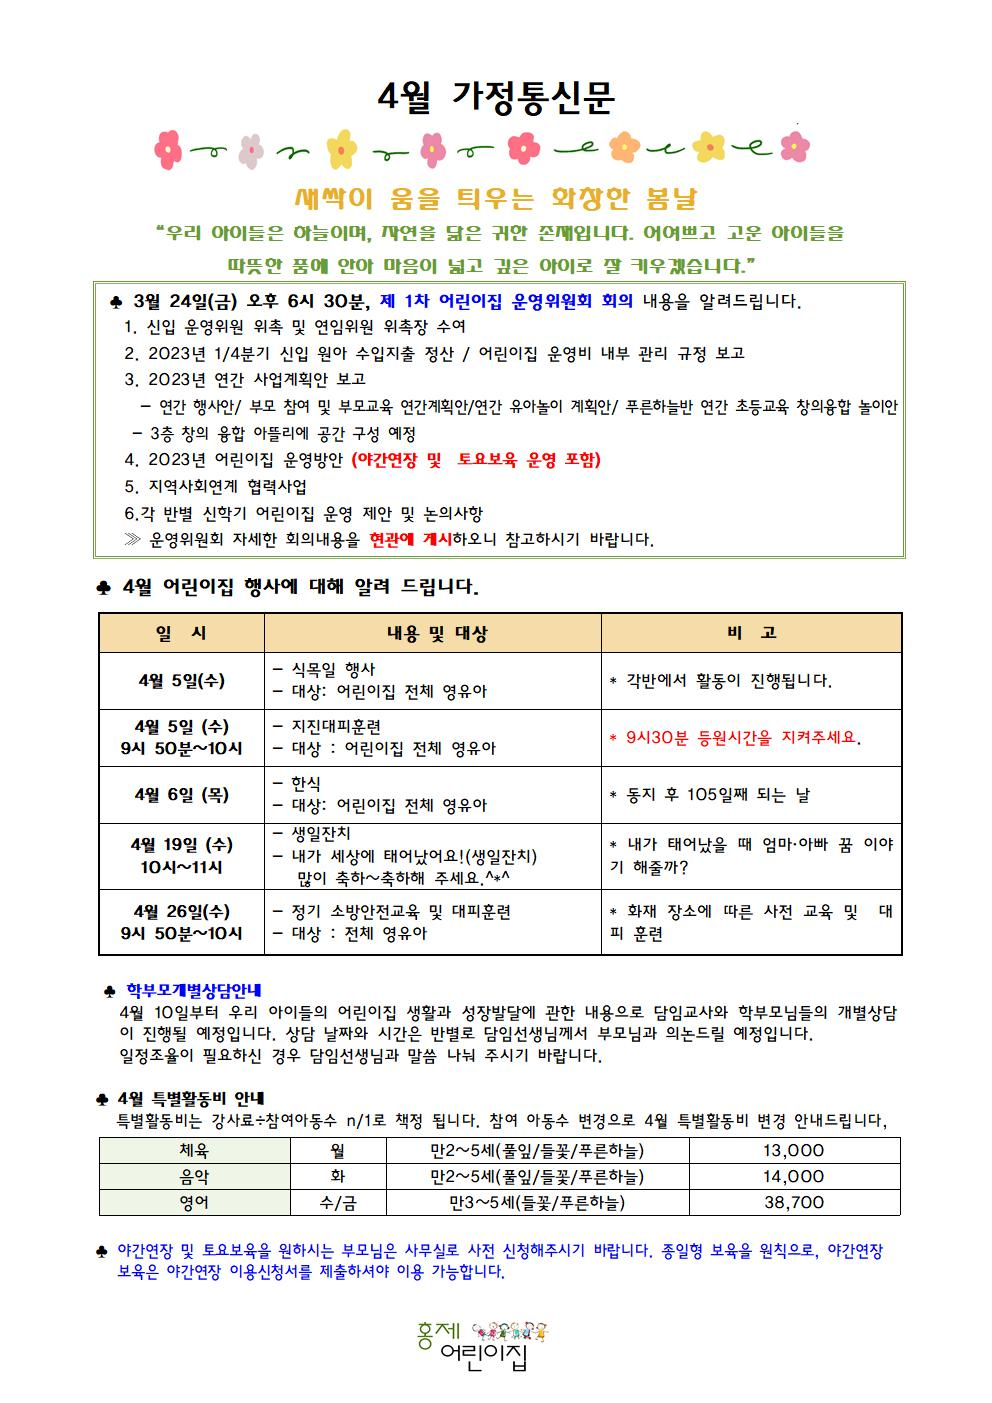

In [24]:
print("Result of easyocr, Token: 3,143")
print("현재 날짜(연도,월): ", response_easy['year_month'])
fix_date(response_easy)
fix_date(response_pororo)
for i in response_easy['events']:
    print(i)

print('-' * 100)
print("Result of pororo, Token: 1,373")
print("현재 날짜(연도,월) :", response_pororo['year_month'])
for i in response_pororo['events']:
    print(i)
print('-' * 100)
Image(img_path, width=500, height=500)